In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-10-24 11:24:24.397755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761305064.702423      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761305064.789932      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
import scipy
if not hasattr(scipy, "interp"):
    scipy.interp = np.interp

import scikitplot.metrics as skplt

In [3]:
IMG_SIZE = 48
BATCH_SIZE = 64
EPOCHS = 25
DATASET_PATH = "/kaggle/input/fer2013"

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="validation"
)

Found 28711 images belonging to 2 classes.
Found 7176 images belonging to 2 classes.


In [5]:
base_model = VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3) 
)

2025-10-24 11:25:23.370081: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
for layer in base_model.layers:
    layer.trainable = False

In [7]:
model = models.Sequential([
    layers.Conv2D(3, (3, 3), padding="same", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation="softmax")
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 3)      │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,156,256 (76.89 MB)

 Trainable params: 131,872 (515.12 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [8]:
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, mode="max")


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 1416s 3s/step - accuracy: 0.7026 - loss: 0.6692 - val_accuracy: 0.8000 - val_loss: 0.5075
Epoch 2/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 1450s 3s/step - accuracy: 0.7978 - loss: 0.5225 - val_accuracy: 0.8000 - val_loss: 0.5025
Epoch 3/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 1434s 3s/step - accuracy: 0.8002 - loss: 0.5114 - val_accuracy: 0.8000 - val_loss: 0.5038
Epoch 4/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 1475s 3s/step - accuracy: 0.8028 - loss: 0.5005 - val_accuracy: 0.8000 - val_loss: 0.5016
Epoch 5/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 1471s 3s/step - accuracy: 0.7970 - loss: 0.5072 - val_accuracy: 0.8000 - val_loss: 0.5014
Epoch 6/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 1480s 3s/step - accuracy: 0.7997 - loss: 0.5008 - val_accuracy: 0.8000 - val_loss: 0.5018
Epoch 7/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 1462s 3s/step - accuracy: 0.8000 - loss: 0.5015 - val_accuracy: 0.8000 - val_loss: 0.5015
Epoch 8/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 1480s 3s/step - accuracy: 0.8011 - loss: 0.4985 - 

In [9]:
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

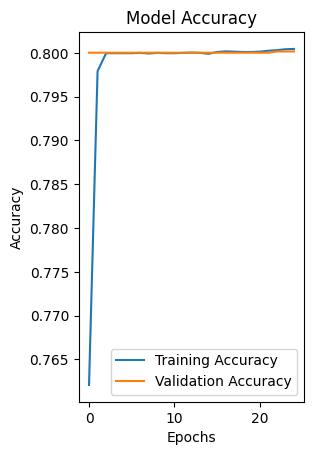

In [10]:
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

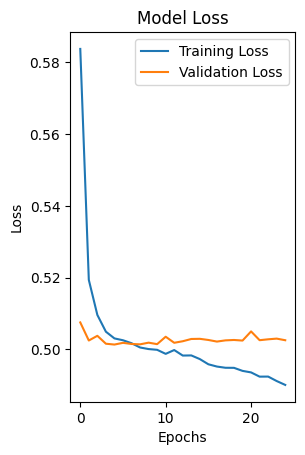

In [11]:
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 110s 970ms/step
              precision    recall  f1-score   support

        test       0.00      0.00      0.00      1435
       train       0.80      1.00      0.89      5741

    accuracy                           0.80      7176
   macro avg       0.40      0.50      0.44      7176
weighted avg       0.64      0.80      0.71      7176



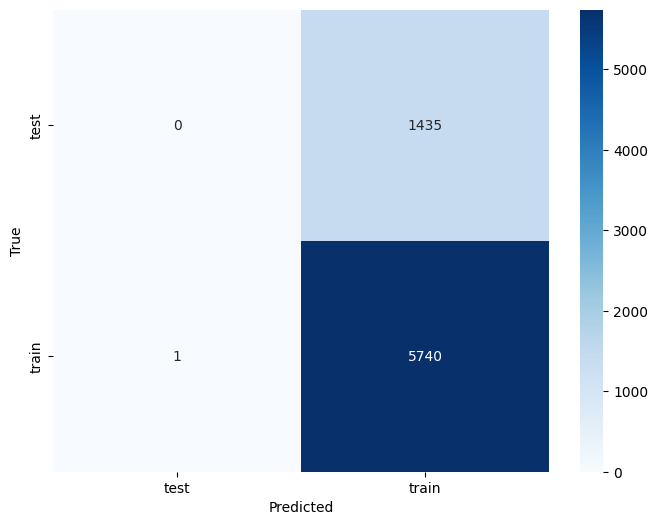

In [12]:
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_true = val_generator.classes
y_pred = np.argmax(preds, axis=1)

print(classification_report(y_true, y_pred, target_names=list(val_generator.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

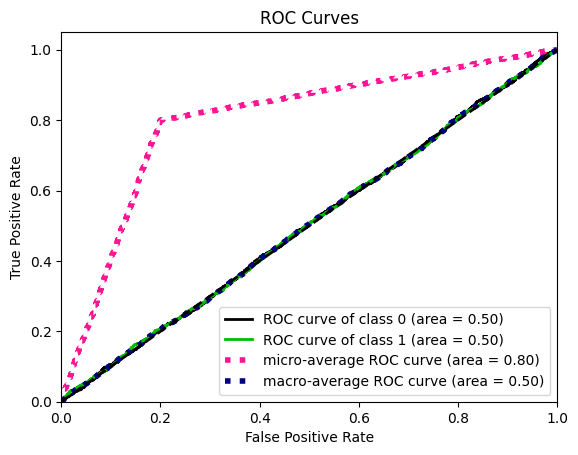

In [13]:
skplt.plot_roc(y_true, preds)
plt.show()